<a href="https://colab.research.google.com/github/EricLBuehler/Automatic-Differentiation-Custom/blob/main/autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Automatic Differentiation

Automatic Differentiation is a core tool used to calculate derivatives which are key to machine learning. This is my personal implementation.

Eric Buehler 2023

In [1]:
# AD
#https://towardsdatascience.com/build-your-own-automatic-differentiation-program-6ecd585eec2a
#https://e-dorigatti.github.io/math/deep%20learning/2020/04/07/autodiff.html
#https://jingnanshi.com/blog/autodiff.html
#https://github.com/karpathy/micrograd
#https://sidsite.com/posts/autodiff/

# Simple NN implementation
#https://mostafa-samir.github.io/auto-diff-pt2/#putting-everything-into-action
#https://stackoverflow.com/questions/67615051/implementing-binary-cross-entropy-loss-gives-different-answer-than-tensorflows

# Softmax derivative
#https://aimatters.wordpress.com/2019/06/17/the-softmax-function-derivative/

In [2]:
from abc import ABC, abstractmethod
from typing import *
from functools import reduce
import numpy as np

Define a base abstract class for all values, and a general OperatorLike class.

In [3]:
class DifferentiableValue(ABC):
    count = 0
    def __init__(self):
        DifferentiableValue.count += 1
        self.id = DifferentiableValue.count 

    @abstractmethod
    def backward(self, var):
        pass

    @abstractmethod
    def forward(self):
        pass

    @abstractmethod
    def __repr__(self) -> str:
        pass

class OperatorLike(ABC):
    pass

General functions

- `generate_topo` topographically sorts a graph, ensuring a directed acyclic graph.

In [4]:
def generate_topo(graph: DifferentiableValue) -> List[DifferentiableValue]:
    topo = []
    visited = set()
    def build_topo(node: DifferentiableValue) -> List[DifferentiableValue]:
        if node not in visited:
            visited.add(node)
            if hasattr(node, "inputs"):
                for input in node.inputs:
                    build_topo(input)
            topo.append(node)
        return topo
    return build_topo(graph)

Define a graph to hold the operations, and a gradient graph to hold gradients.

In [5]:
class GradientGraph:
    def __init__(self, graph: List[DifferentiableValue]):
        self.graph = graph
    
    def wrt(self, var: Union[DifferentiableValue, np.ndarray]) -> np.ndarray:
        if isinstance(var,  np.ndarray):
            array = []
            for item in np.nditer(var.flatten(),["refs_ok"]):
                if item not in self.graph:
                    raise KeyError(f"Variable {var} not found in gradient graph.")
                
                for v in self.graph:
                    if v == item:
                        array.append(v)
            return np.array(array)


        if var not in self.graph:
            raise KeyError(f"Variable {var} not found in gradient graph.")
        for v in self.graph:
            if v == var:
                return v.gradient

    def __repr__(self):
        return "GradientGraph: {}".format(", ".join([str(item) for item in self.graph]))

class Graph:
    def __init__(self):
        self.values = []
        global _graph
        _graph = self
        self.has_backwarded = False
        self.clean_graph = lambda values: (values := values[:-1])

    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        pass

    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        self.clean_graph(self.values)
        return self.values[-1].forward()

    def backward(self) -> np.ndarray:
        self.clean_graph(self.values)
        graph = self.values.copy()
        res = self.values[-1].backward()
        self.values = graph
        self.has_backwarded = True
        return res

    def __repr__(self):
        return "Graph: {}".format(", ".join([str(item) for item in self.values]))

In [6]:
def create_gradient_graph(item) -> GradientGraph:
    filtered = set()
    topo = generate_topo(item)
    for value in topo:
        if not (isinstance(value, OperatorLike) and isinstance(value, Variable)):
            filtered.add(value)
            
    return GradientGraph(list(filtered))

Define constant and variable values.

The `.backward` functions return the derivative of constants and variables.

In [7]:
class Constant(DifferentiableValue):
    count = 0

    def __init__(self, value: Union[SupportsFloat, np.ndarray]):
        super().__init__()
        self.value = value
        Constant.count += 1
        
        self.gradient = 0
        
    def backward(self):
        self.gradient = 0
                
        return _graph
        
    def forward(self) -> Any:
        return self.value

    def __repr__(self) -> str:
        return f"Constant({self.value}, g={self.gradient})"

class Variable(DifferentiableValue):
    count = 0

    def __init__(self, value: Union[SupportsFloat, np.ndarray] = None, name = None):
        super().__init__()
        self._value = value
        self.name = name
        Variable.count += 1
        
        self.gradient = 0
        
    def backward(self):
        self.gradient = 1
                
        return self
    
    @property
    def value(self):
        return self._value
    
    @value.setter
    def value(self, value):
        if self.value == None:
            raise ValueError("Variable does not have value")
        self._value = value
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        if self.value == None:
            raise ValueError("Variable does not have value")
        return self.value

    def __repr__(self) -> str:
        return f"Variable('{self.name}' {self.value}, g={self.gradient})"

Define operation "nodes" that act like values.

The `.backward` functions return the effective value after applying the chain rule, for sums, products, and powers.

Note that the `self.gradient = 1` essentially means that the gradient of y with respect to y is 1 (because `self` is the first element of `reversed(topo`).

See https://jingnanshi.com/blog/autodiff.html for a great explanation.
Note that the equations above table 1 show how the gradients are accumulated, like can be seen in the `_backward` functions.

In [8]:
class Sum(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, left: DifferentiableValue, right:  DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [left, right]
        Sum.count += 1
        
        self.gradient = 0

        def _backward():
            for input in self.inputs:
                input.gradient += self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return sum([input.forward() for input in self.inputs])
    
    def __repr__(self) -> str:
        return "Sum({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Product(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, left: DifferentiableValue, right:  DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [left, right]
        Product.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += self.inputs[1].forward() * self.gradient
            self.inputs[1].gradient += self.inputs[0].forward() * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return reduce((lambda x, y: x * y), [input.forward() for input in self.inputs])

    def __repr__(self) -> str:
        return "Product({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Power(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, base: DifferentiableValue, pow:  DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [base, pow]
        Power.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (self.inputs[1].forward() * self.inputs[0].forward() ** (self.inputs[1] - 1).forward()) * self.gradient
            self.inputs[1].gradient += abs(np.log(self.inputs[0].forward())) * self.inputs[0].forward() ** (self.inputs[1].forward()) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return reduce((lambda x, y: x ** y), [input.forward() for input in self.inputs])

    def __repr__(self) -> str:
        return "Power({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

Trigonometric and other functions

In [9]:
class Sine(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Sine.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += np.cos(self.inputs[0].forward()) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.sin(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Sine({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Cosine(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Cosine.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += -np.sin(self.inputs[0].forward()) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.cos(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Cosine({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Tangent(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Tangent.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (1 / (np.cos(self.inputs[0].forward())**2)) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.tan(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Tangent({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Log(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Sine.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (1 / self.inputs[0].forward()) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.log(abs(self.inputs[0].forward()))

    def __repr__(self) -> str:
        return "Log({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Exp(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Sine.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (np.exp(self.inputs[0].forward())) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.exp(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Log({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

Activation Functions

In [10]:
class ReLU(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        ReLU.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (1 if self.inputs[0].forward() > 0 else 0) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return max(0, self.inputs[0].forward())

    def __repr__(self) -> str:
        return "ReLU({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class LeakyReLU(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue, negative_slope: SupportsFloat = 0.01):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        self.negative_slope = negative_slope
        LeakyReLU.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (1 if self.inputs[0].forward() >= 0 else self.negative_slope) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.array([self.inputs[0].forward() if self.inputs[0].forward() >= 0 else self.inputs[0].forward() * self.negative_slope])

    def __repr__(self) -> str:
        return "LeakyReLU({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Sigmoid(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Sigmoid.count += 1
        
        self.gradient = 0

        def _backward():
            x = self.inputs[0].forward()
            self.inputs[0].gradient += (self.sigmoid(x) * (1-self.sigmoid(x))) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
    
    @staticmethod
    def sigmoid(x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return self.sigmoid(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Sigmoid({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Softmax(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, *inputs: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = inputs
        Softmax.count += 1
        
        self.gradient = 0

        def _backward():
            softmax = self.softmax()
            softmax_vector = softmax.reshape(softmax.shape[0],1)
            softmax_matrix = np.tile(softmax_vector,softmax.shape[0])
            self.inputs[0].gradient += (np.diag(softmax) - (softmax_matrix * np.transpose(softmax_matrix))) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self

    def softmax(self) -> np.ndarray:
        denom = sum([np.exp(input.forward()) for input in self.inputs])
        return np.array([np.exp(input.forward()) / denom for input in self.inputs])
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        denom = sum([np.exp(input.forward()) for input in self.inputs])
        return np.array([np.exp(input.forward()) / denom for input in self.inputs])

    def __repr__(self) -> str:
        return "Softmax({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

Hyperbolic trig functions

In [11]:
class Tanh(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Tanh.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (1 / (np.cosh(self.inputs[0].forward())**2)) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.tanh(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Tanh({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Cosh(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Cosh.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (np.sinh(self.inputs[0].forward())) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.cosh(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Cosh({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

class Sinh(DifferentiableValue, OperatorLike):
    count = 0

    def __init__(self, x: DifferentiableValue):
        super().__init__()
        _graph.values.append(self)
        self.inputs = [x]
        Sinh.count += 1
        
        self.gradient = 0

        def _backward():
            self.inputs[0].gradient += (np.cosh(self.inputs[0].forward())) * self.gradient

        self._backward = _backward
        
    def backward(self):
        topo = generate_topo(self)
        
        self.gradient = 1
        for node in reversed(topo):
            if hasattr(node, "_backward"):
                node._backward()
                
        return self
        
    def forward(self) -> Union[np.ndarray, SupportsFloat]:
        return np.cosh(self.inputs[0].forward())

    def __repr__(self) -> str:
        return "Sinh({}, g={})".format(', '.join([str(input) for input in self.inputs]), self.gradient)

Losses

In [12]:
class CrossEntropyLoss:
    def __call__(self, outputs: np.ndarray, targets: np.ndarray):
        log = np.vectorize(lambda x: Log(x))
        term_0 = (-outputs+1) * log(-targets + 1 + 1e-7)
        term_1 = outputs * log(targets + 1e-7)
        res = list((-term_0+term_1).flatten())
        
        return np.sum(res)/len(res)

class MSELoss:
    def __call__(self, outputs: np.ndarray, targets: np.ndarray):
        lossv = (targets - outputs) * (targets - outputs)
        return np.sum(lossv)/sum(lossv.shape)

np_vectorize = np.vectorize(lambda x : Variable(x))

Define a `generate_operation` function to act as a closure and preform runtime "type replacement" to convert `SupportsFloat` types into `DifferentiableValue`.

In [13]:
def generate_operation(op, self: DifferentiableValue, other: Union[DifferentiableValue, SupportsFloat]):
    if isinstance(other, DifferentiableValue):
        return op(self, other)
    if isinstance(other, (SupportsFloat)):
        return op(self, Constant(other))
    raise TypeError(f"Incompatible type for operation: {type(other)}.")

DifferentiableValue.__add__ = lambda self, other: generate_operation(Sum, self, other)
DifferentiableValue.__sub__ = lambda self, other: self + -other
DifferentiableValue.__neg__ = lambda self: self * -1
DifferentiableValue.__mul__ = lambda self, other: generate_operation(Product, self, other)
DifferentiableValue.__pow__ = lambda self, other: generate_operation(Power, self, other)
DifferentiableValue.__truediv__ = lambda self, other: self * (other ** -1)

Test case:

In [14]:
with Graph() as graph:
    x = Variable(0.458, "x")
    y = Sigmoid(Exp(x))
    
print("Raw Graph:")
print(graph.values)
print()

print("Topological Graph:")
topo = generate_topo(y)
for item in topo:
    print(item)
print()

print("Forward value:")
print(graph.forward())
print()
print()

print("Backward graph:")
graph.backward()
print(graph.values)
print()

grad_graph = create_gradient_graph(graph.backward())
print(grad_graph.wrt(x))

del graph

Raw Graph:
[Log(Variable('x' 0.458, g=0), g=0), Sigmoid(Log(Variable('x' 0.458, g=0), g=0), g=0)]

Topological Graph:
Variable('x' 0.458, g=0)
Log(Variable('x' 0.458, g=0), g=0)
Sigmoid(Log(Variable('x' 0.458, g=0), g=0), g=0)

Forward value:
0.829333216455861


Backward graph:
[Log(Variable('x' 0.458, g=0.22376127937065252), g=0.141539632538837), Sigmoid(Log(Variable('x' 0.458, g=0.22376127937065252), g=0.141539632538837), g=1)]

0.6712838381119576


In [15]:
class Network:
    def __init__(self, lrate = 1e-2):
        self.attrs = dir(self)
        self.lrate = lrate
        self.layers = []

    def register(self):
        for attr in dir(self):
            if attr not in self.attrs:
                if isinstance(getattr(self, attr), NetworkOperation):
                    self.layers.append(getattr(self, attr))

    def backward(self, grads):
        for layer in self.layers:
            layer.backward(grads, self.lrate)

class NetworkOperation(ABC):
    def __init__(self, *vars):
        self.vars = vars

In [16]:
class Linear(NetworkOperation):
    def __init__(self, input_features, output_features):
        self.input_features = input_features
        self.output_features = output_features
        self.weights = np_vectorize( np.random.random((input_features, output_features)))
        super().__init__(self.weights)

    def backward(self, grad, lrate):
        grads = grad.wrt(self.weights)
        for i, weight in np.ndenumerate(self.weights):
            weight.value -= lrate * list(grads)[sum(i)].forward()
    
    def __call__(self, x):
        return np.dot(x, self.weights)

In [17]:
class Model(Network):
    def __init__(self, input_size, mid_size, output_size):
        super().__init__()
        self.inp = Linear(input_size, mid_size)
        self.middle = Linear(mid_size, mid_size)
        self.output = Linear(mid_size, output_size)
        super().register()

    def forward(self, x):
        inp = self.inp(x)
        mid = self.middle(inp)
        return self.output(mid)

100%|██████████| 75/75 [00:48<00:00,  1.55it/s]


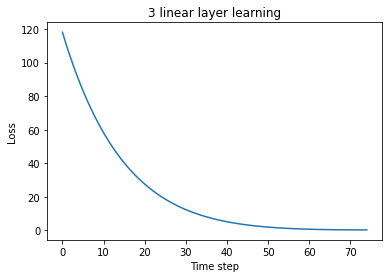

Final loss: 0.20670482563217463


In [18]:
import matplotlib.pyplot as plt
import tqdm
np.random.seed(0)

input_size = 5
mid_size = 6
output_size = 10

x = np_vectorize(np.random.random(input_size))
y_true = np_vectorize(np.random.random(output_size))

mod = Model(input_size, mid_size, output_size)
criterion = MSELoss()


losses = []
with Graph() as graph:
    for i in tqdm.tqdm(range(75)):
        y_pred = mod.forward(x)
        loss = criterion(y_true, y_pred)
        losses.append(loss.forward())

        grad_graph = create_gradient_graph(loss.backward())
        mod.backward(grad_graph)

plt.plot(losses)
plt.xlabel("Time step")
plt.ylabel("Loss")
plt.title("3 linear layer learning")
plt.show()

del graph

print("Final loss: "+str(losses[-1]))

100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


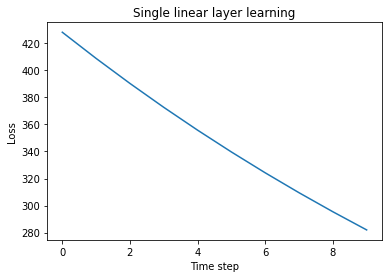

In [19]:
import matplotlib.pyplot as plt
import tqdm
np.random.seed(0)

input_size = 5
output_size = 10
lrate = 0.01

def update_weights(weights, gradients, lrate):
    for i, weight in np.ndenumerate(weights):
        weight.value -= lrate * list(gradients)[sum(i)].forward()

x = np_vectorize(np.random.random(input_size))
y_true = np_vectorize(np.random.random(output_size))
weights = np_vectorize(np.random.random((input_size, output_size)))
weights2 = np_vectorize(np.random.random((output_size, output_size)))

losses = []
with Graph() as graph:
    for i in tqdm.tqdm(range(10)):
        m = np.dot(x, weights)
        y_pred = np.dot(m, weights2)
        loss = np.sum((y_true - y_pred) * (y_true - y_pred))
        losses.append(loss.forward())

        grad_graph = create_gradient_graph(loss.backward())
        update_weights(weights, grad_graph.wrt(weights), lrate)
        update_weights(weights2, grad_graph.wrt(weights2), lrate)

plt.plot(losses)
plt.xlabel("Time step")
plt.ylabel("Loss")
plt.title("Single linear layer learning")
plt.show()


del graph